<a href="https://colab.research.google.com/github/pierredantas/RMT_for_Denoising_Large-Scale_Neural_Network_Weights/blob/main/RMT_for_Denoising_Large_Scale_Neural_Network_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RMT_for_Denoising_Large-Scale_Neural_Network_Weights

# Pre-Processing

## Load BERT and extract original matrices

In [ ]:
# extract_bert_matrices.py
from pathlib import Path
import json
import numpy as np
import torch
from transformers import BertModel

def extract_matrices(
    model_name: str = "bert-base-uncased",
    out_dir: str = "bert_weights",
    include_bias: bool = False,
    only_linear_like: bool = True,      # skip LayerNorm/embeddings unless they are 2-D
    dtype: str = "float32",             # "float32" | "float64"
    save_format: str = "npy",           # "npy" | "npz" (np.savez_compressed)
):
    """
    Extracts all weight matrices from a HuggingFace BERT and saves them with a manifest.
    """
    assert save_format in {"npy", "npz"}
    np_dtype = np.float32 if dtype == "float32" else np.float64

    # 1) Load model on CPU, no grad
    torch.set_grad_enabled(False)
    model = BertModel.from_pretrained(model_name)
    model.eval()
    model.to("cpu")

    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    # 2) Iterate state_dict for robustness (covers all submodules)
    sd = model.state_dict()
    manifest = {
        "model_name": model_name,
        "dtype": dtype,
        "include_bias": include_bias,
        "only_linear_like": only_linear_like,
        "files": []
    }

    # Helper to filter which tensors to keep
    def keep_param(key: str, tensor: torch.Tensor) -> bool:
        # Want weights (2-D) from linear/attention/FFN; optionally biases (1-D)
        if tensor.ndim == 2:
            # Typically Linear weights, embedding matrices (2-D), etc.
            if only_linear_like:
                # Heuristics: keep common linear/attention/FFN matrices
                names_we_like = (
                    "encoder.layer", "attention", "intermediate", "output.dense",
                    "self.query", "self.key", "self.value", "dense", "pooler.dense"
                )
                return any(n in key for n in names_we_like)
            return True

        if include_bias and tensor.ndim == 1:
            # keep biases if requested
            names_we_like = ("bias",)
            return any(n in key for n in names_we_like)

        return False

    # 3) Save tensors and record metadata
    for key in sorted(sd.keys()):
        t = sd[key]
        if not keep_param(key, t):
            continue

        arr = t.detach().cpu().to(dtype=torch.float32 if dtype == "float32" else torch.float64).numpy()

        # Build a safe, hierarchical path
        # Example key: "encoder.layer.0.attention.self.query.weight"
        # -> encoder/layer_0/attention/self/query/weight.npy
        parts = key.split(".")
        # normalize "layer.N" to "layer_N"
        norm_parts = []
        for p in parts:
            if p == "layer":
                continue
            if p.isdigit():  # the index that follows "layer"
                norm_parts.append(f"layer_{p}")
            else:
                norm_parts.append(p)

        # Put under base directory
        save_dir = out.joinpath(*norm_parts[:-1])  # all but the last (usually "weight" or "bias")
        save_dir.mkdir(parents=True, exist_ok=True)

        stem = norm_parts[-1]  # "weight" or "bias"
        ext = ".npy" if save_format == "npy" else ".npz"
        path = save_dir / f"{stem}{ext}"

        if save_format == "npy":
            np.save(path, arr)
        else:
            np.savez_compressed(path, data=arr)

        manifest["files"].append({
            "name": key,
            "path": str(path.relative_to(out)),
            "shape": list(arr.shape),
            "ndim": arr.ndim,
            "dtype": str(arr.dtype)
        })

    # 4) Also save a flat copy for embeddings if you want them explicitly grouped
    # (Optional—comment out if you don't need a separate embeddings folder)
    emb_dir = out / "embeddings"
    emb_dir.mkdir(exist_ok=True)
    for subkey, param in model.embeddings.state_dict().items():
        if param.ndim == 2 or (include_bias and param.ndim == 1):
            arr = param.detach().cpu().to(dtype=torch.float32 if dtype == "float32" else torch.float64).numpy()
            fname = (subkey.replace(".", "_") + ("_bias" if subkey.endswith("bias") else "") +
                     (".npy" if save_format == "npy" else ".npz"))
            path = emb_dir / fname
            if save_format == "npy":
                np.save(path, arr)
            else:
                np.savez_compressed(path, data=arr)

            manifest["files"].append({
                "name": f"embeddings.{subkey}",
                "path": str(path.relative_to(out)),
                "shape": list(arr.shape),
                "ndim": arr.ndim,
                "dtype": str(arr.dtype)
            })

    # 5) Write manifest
    with open(out / "manifest.json", "w") as f:
        json.dump(manifest, f, indent=2)

    print(f"Saved to: {out.resolve()}")
    print(f"Total tensors saved: {len(manifest['files'])}")

if __name__ == "__main__":
    extract_matrices(
        model_name="bert-base-uncased",
        out_dir="bert_weights",
        include_bias=False,
        only_linear_like=True,
        dtype="float32",
        save_format="npy",
    )

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Saved to: /content/bert_weights
Total tensors saved: 76


## Build Wn and save stats

In [ ]:
# =========================
# Build WMP and save stats for inversion
# =========================
# Inputs:
#   - bert_weights/ (from extract_bert_matrices.py)
# Outputs:
#   - step1_column_stats.json   (human-readable, key map)
#   - step1_column_stats.npz    (exact np arrays of means/stds)
#   - bert_weights_WMP/          (normalized matrices) + manifest.json

import json
import re
from datetime import datetime, UTC
from pathlib import Path
import numpy as np

WEIGHTS_DIR = "bert_weights"
STATS_JSON  = "step1_column_stats.json"
STATS_NPZ   = "step1_column_stats.npz"
WMP_DIR      = "bert_weights_WMP"

def _safe_key(idx: int, kind: str, name: str) -> str:
    """Create stable NPZ keys like '0003__mean__encoder_layer_0_attention_self_query_weight'."""
    base = f"{idx:04d}__{kind}__" + re.sub(r"[^0-9a-zA-Z_]+", "_", name)
    base = re.sub(r"__+", "__", base).strip("_")
    return base[:200]

def _load_matrix(path: Path) -> np.ndarray:
    if path.suffix == ".npy":
        return np.load(path)
    if path.suffix == ".npz":
        return np.load(path)["data"]
    raise ValueError(f"Unsupported file type: {path.suffix}")

def _save_npy(path: Path, arr: np.ndarray) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    np.save(path, arr)

# ------------- Step 1: compute and save column-wise stats -------------
weights_dir = Path(WEIGHTS_DIR)
manifest_path = weights_dir / "manifest.json"
assert manifest_path.exists(), f"Manifest not found at {manifest_path}"

with open(manifest_path, "r") as f:
    manifest = json.load(f)

npz_store = {}
stats_json = {
    "model_name": manifest.get("model_name", ""),
    "created_at": datetime.now(UTC).isoformat(),
    "weights_dir": str(weights_dir),
    "count_files": 0,
    "files": []
}

files = manifest.get("files", [])
processed = 0
for idx, entry in enumerate(files):
    relpath = entry.get("path")
    name    = entry.get("name", relpath)
    shape   = entry.get("shape")

    fpath = weights_dir / relpath
    if not fpath.exists():
        print(f"[MISS] {relpath}")
        continue

    try:
        W = _load_matrix(fpath)
    except Exception as e:
        print(f"[LOAD-ERR] {relpath}: {e}")
        continue

    if W.ndim != 2:
        continue  # only 2-D matrices

    # Column-wise stats (axis=0); compute in float64 for stability
    W = W.astype(np.float64, copy=False)
    mu = W.mean(axis=0)          # shape (n,)
    sd = W.std(axis=0)           # shape (n,)

    mean_key = _safe_key(idx, "mean", name)
    std_key  = _safe_key(idx, "std",  name)
    npz_store[mean_key] = mu
    npz_store[std_key]  = sd

    stats_json["files"].append({
        "index": idx,
        "name": name,
        "path": relpath,
        "shape": shape,
        "npz_keys": {"mean": mean_key, "std": std_key},
        "summary": {
            "mean_of_means": float(mu.mean()),
            "mean_of_stds": float(sd.mean()),
            "max_std": float(sd.max()),
            "min_std": float(sd.min())
        }
    })
    processed += 1
    if processed % 25 == 0:
        print(f"[STATS] Processed {processed} matrices...")

stats_json["count_files"] = processed

with open(STATS_JSON, "w") as jf:
    json.dump(stats_json, jf, indent=2)
np.savez_compressed(STATS_NPZ, **npz_store)

print(f"[STATS] Done. Matrices processed: {processed}")
print(f"[STATS] JSON: {STATS_JSON}")
print(f"[STATS] NPZ : {STATS_NPZ}")

# ------------- Step 2: build WMP=(W - 1*mu)/sd and save with manifest -------------
out_root = Path(WMP_DIR)
out_root.mkdir(parents=True, exist_ok=True)

# prepare WMP manifest (clone key fields)
wmp_manifest = {
    "model_name": manifest.get("model_name", "") + " (column-standardized)",
    "dtype": "float64",
    "include_bias": manifest.get("include_bias", False),
    "only_linear_like": manifest.get("only_linear_like", True),
    "files": []
}

stats_npz = np.load(STATS_NPZ)

saved = 0
skipped = 0
for entry in stats_json["files"]:
    relpath = entry["path"]
    name    = entry["name"]
    mu      = stats_npz[entry["npz_keys"]["mean"]]  # (n,)
    sd      = stats_npz[entry["npz_keys"]["std"]]   # (n,)

    src_path = weights_dir / relpath
    if not src_path.exists():
        print(f"[MISS-WMP] {relpath}")
        continue

    W = _load_matrix(src_path)
    if W.ndim != 2:
        skipped += 1
        continue

    W = W.astype(np.float64, copy=False)

    # Guard zero-variance columns; they remain constant after normalization
    safe_sd = np.where(sd == 0, 1.0, sd)

    # WMP = (W - 1*mu)/sd  -> broadcast along rows (axis=0)
    WMP = (W - mu.reshape(1, -1)) / safe_sd.reshape(1, -1)

    dst_path = out_root / relpath
    _save_npy(dst_path, WMP)

    wmp_manifest["files"].append({
        "name": name.replace(".weight", ".weight_WMP"),
        "path": str(dst_path.relative_to(out_root)),
        "shape": list(WMP.shape),
        "ndim": 2,
        "dtype": str(WMP.dtype)
    })
    saved += 1
    if saved % 25 == 0:
        print(f"[WMP] Saved {saved} matrices...")

with open(out_root / "manifest.json", "w") as f:
    json.dump(wmp_manifest, f, indent=2)

# ------------- Quick verification on a few matrices -------------
from itertools import islice

def _check_one(relpath: str, mu: np.ndarray, sd: np.ndarray) -> float:
    W  = _load_matrix(weights_dir / relpath).astype(np.float64)
    WMP = _load_matrix(out_root / relpath).astype(np.float64)
    safe_sd = np.where(sd == 0, 1.0, sd)
    W_rec = WMP * safe_sd.reshape(1, -1) + mu.reshape(1, -1)
    return float(np.max(np.abs(W - W_rec)))

print("====================================================")
print(f"✅ WMP saved: {saved} | Skipped (non-2D): {skipped}")
print(f"Manifest written: {out_root / 'manifest.json'}")

# Pick up to 3 entries and verify round-trip reconstruction
errs = []
for e in islice(stats_json["files"], 3):
    rel = e["path"]
    mu  = stats_npz[e["npz_keys"]["mean"]]
    sd  = stats_npz[e["npz_keys"]["std"]]
    errs.append((rel, _check_one(rel, mu, sd)))
for rel, err in errs:
    print(f"[CHECK] {rel}: max |W - (WMP*sd+mu)| = {err:.3e}")
print("====================================================")


[STATS] Processed 25 matrices...
[STATS] Processed 50 matrices...
[STATS] Processed 75 matrices...
[STATS] Done. Matrices processed: 76
[STATS] JSON: step1_column_stats.json
[STATS] NPZ : step1_column_stats.npz
[WMP] Saved 25 matrices...
[WMP] Saved 50 matrices...
[WMP] Saved 75 matrices...
✅ WMP saved: 76 | Skipped (non-2D): 0
Manifest written: bert_weights_WMP/manifest.json
[CHECK] encoder/layer_0/attention/output/dense/weight.npy: max |W - (WMP*sd+mu)| = 2.776e-17
[CHECK] encoder/layer_0/attention/self/key/weight.npy: max |W - (WMP*sd+mu)| = 1.110e-16
[CHECK] encoder/layer_0/attention/self/query/weight.npy: max |W - (WMP*sd+mu)| = 5.551e-17


# MP CDF and PDF

<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:76: SyntaxWarning: invalid escape sequence '\l'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:76: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1659963148.py:75: SyntaxWarning: invalid escape sequence '\l'
  ax1.axvline(x=lambda_minus, color='r', linestyle='--', label=f"$\lambda_-$ = {lambda_minus:.2f}")
/tmp/ipython-input-1659963148.py:76: SyntaxWarning: invalid escape sequence '\l'
  ax1.axvline(x=lambda_plus, color='g', linestyle='--', label=f"$\lambda_+$ = {lambda_plus:.2f}")


Available WMP matrices:
[0] encoder.layer.0.attention.output.dense.weight_WMP (Shape: 768x768)
[1] encoder.layer.0.attention.self.key.weight_WMP (Shape: 768x768)
[2] encoder.layer.0.attention.self.query.weight_WMP (Shape: 768x768)
[3] encoder.layer.0.attention.self.value.weight_WMP (Shape: 768x768)
[4] encoder.layer.0.intermediate.dense.weight_WMP (Shape: 3072x768)
[5] encoder.layer.0.output.dense.weight_WMP (Shape: 768x3072)
[6] encoder.layer.1.attention.output.dense.weight_WMP (Shape: 768x768)
[7] encoder.layer.1.attention.self.key.weight_WMP (Shape: 768x768)
[8] encoder.layer.1.attention.self.query.weight_WMP (Shape: 768x768)
[9] encoder.layer.1.attention.self.value.weight_WMP (Shape: 768x768)
[10] encoder.layer.1.intermediate.dense.weight_WMP (Shape: 3072x768)
[11] encoder.layer.1.output.dense.weight_WMP (Shape: 768x3072)
[12] encoder.layer.10.attention.output.dense.weight_WMP (Shape: 768x768)
[13] encoder.layer.10.attention.self.key.weight_WMP (Shape: 768x768)
[14] encoder.layer.1

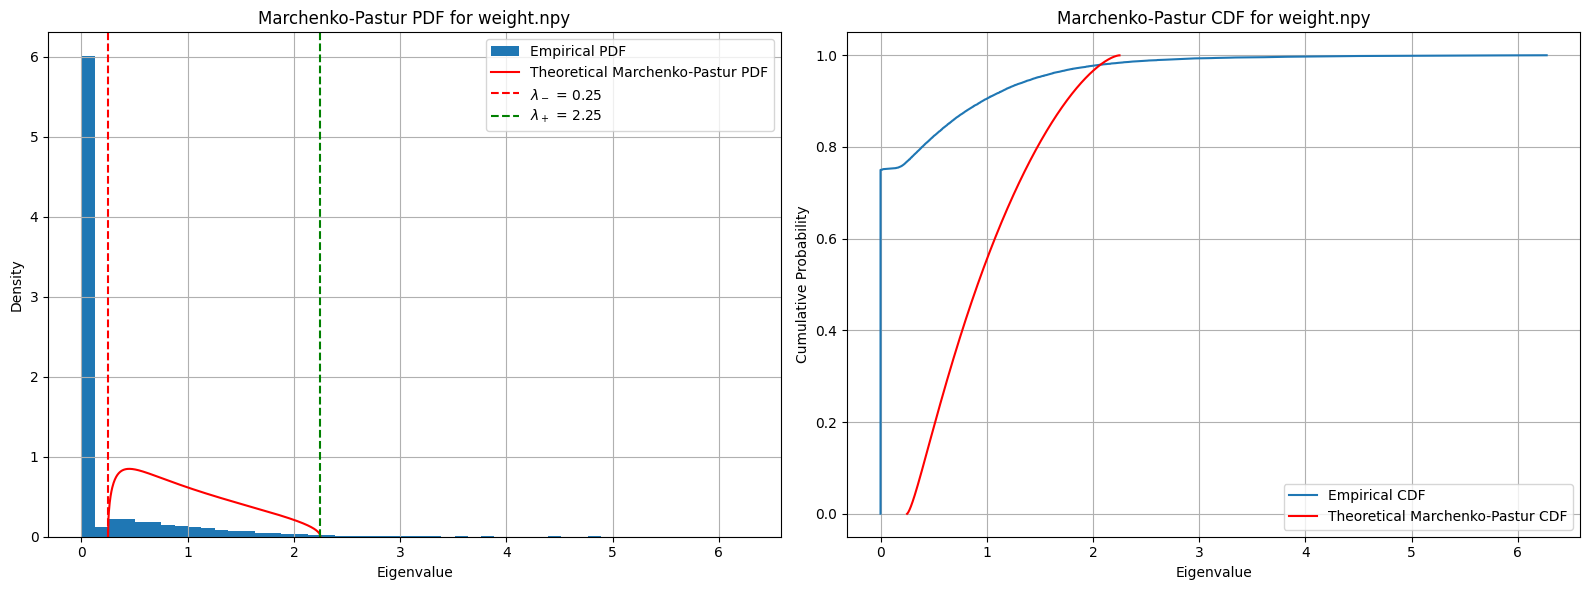

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import os

# Define the root directory for your WMP matrices
WMP_DIR = "bert_weights_WMP"
MANIFEST_PATH = Path(WMP_DIR) / "manifest.json"

def get_wmp_matrices_from_manifest(manifest_file_path):
    """
    Loads the manifest file and returns a list of available WMP matrices.
    """
    if not os.path.exists(manifest_file_path):
        print(f"Error: Manifest file not found at '{manifest_file_path}'")
        return []

    with open(manifest_file_path, 'r') as f:
        manifest = json.load(f)

    return manifest['files']

def plot_marchenko_pastur(matrix_path, m, n):
    """
    Loads a WMP matrix, calculates its empirical and theoretical Marchenko-Pastur
    distributions (PDF and CDF), and plots them.

    Args:
        matrix_path (str): The full path to the .npy file.
        m (int): The number of rows of the matrix.
        n (int): The number of columns of the matrix.
    """
    try:
        WMP = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Error: Matrix file not found at '{matrix_path}'")
        return

    # Ensure m and n match the matrix dimensions
    if WMP.shape != (m, n):
        print(f"Warning: Provided dimensions ({m}x{n}) don't match matrix shape {WMP.shape}. Using matrix shape.")
        m, n = WMP.shape

    # Transpose if m > n to ensure q <= 1
    if m > n:
        print("Note: Transposing matrix to ensure m <= n for WMP calculation.")
        WMP = WMP.T
        m, n = WMP.shape

    # Calculate the aspect ratio (q)
    q = m / n

    # Re-calculate based on the file contents
    # The theory applies to the eigenvalues of the covariance matrix (WMP.T @ WMP).
    # We scale by (1/n) to normalize.
    eigenvalues = np.linalg.eigvalsh((1/n) * WMP.T @ WMP)

    # Calculate the theoretical limits
    sigma_squared = 1.0  # Assumed for a standardized matrix
    lambda_minus = sigma_squared * (1 - np.sqrt(q))**2
    lambda_plus = sigma_squared * (1 + np.sqrt(q))**2

    # Generate the theoretical PDF curve
    x_mp = np.linspace(lambda_minus, lambda_plus, 500)
    pdf_mp = (1 / (2 * np.pi * sigma_squared * x_mp * q)) * np.sqrt((lambda_plus - x_mp) * (x_mp - lambda_minus))

    # --- Plotting PDFs and CDFs side-by-side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: PDF (Probability Density Function)
    ax1.set_title(f"Marchenko-Pastur PDF for {os.path.basename(matrix_path)}")
    ax1.hist(eigenvalues, bins=50, density=True, label="Empirical PDF")
    ax1.plot(x_mp, pdf_mp, 'r', label="Theoretical Marchenko-Pastur PDF")
    ax1.axvline(x=lambda_minus, color='r', linestyle='--', label=f"$\lambda_-$ = {lambda_minus:.2f}")
    ax1.axvline(x=lambda_plus, color='g', linestyle='--', label=f"$\lambda_+$ = {lambda_plus:.2f}")
    ax1.set_xlabel("Eigenvalue")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: CDF (Cumulative Distribution Function)
    # Empirical CDF
    sorted_eigenvalues = np.sort(eigenvalues)
    empirical_cdf = np.arange(1, len(sorted_eigenvalues) + 1) / len(sorted_eigenvalues)

    # Theoretical CDF (by numerical integration of the PDF)
    theoretical_cdf = np.cumsum(pdf_mp) * (x_mp[1] - x_mp[0])

    ax2.set_title(f"Marchenko-Pastur CDF for {os.path.basename(matrix_path)}")
    ax2.plot(sorted_eigenvalues, empirical_cdf, label="Empirical CDF")
    ax2.plot(x_mp, theoretical_cdf, 'r', label="Theoretical Marchenko-Pastur CDF")
    ax2.set_xlabel("Eigenvalue")
    ax2.set_ylabel("Cumulative Probability")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- Main execution ---
if __name__ == "__main__":
    matrices = get_wmp_matrices_from_manifest(MANIFEST_PATH)
    if not matrices:
        exit()

    print("Available WMP matrices:")
    for i, entry in enumerate(matrices):
        print(f"[{i}] {entry['name']} (Shape: {entry['shape'][0]}x{entry['shape'][1]})")

    try:
        choice = int(input("Enter the number of the matrix you want to plot: "))
        if 0 <= choice < len(matrices):
            selected_matrix = matrices[choice]
            matrix_path = os.path.join(WMP_DIR, selected_matrix['path'])
            m, n = selected_matrix['shape']
            plot_marchenko_pastur(matrix_path, m, n)
        else:
            print("Invalid choice. Please enter a number from the list.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# FINAL WITH GRAPHS

<>:140: SyntaxWarning: invalid escape sequence '\p'
<>:140: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-252539087.py:140: SyntaxWarning: invalid escape sequence '\p'
  ax2.fill_between(x_trimmed, lower_bound, upper_bound, color='blue', alpha=0.1, label=f'Acceptance Region ($\pm$Dcrit)')


Available WMP matrices:
[0] encoder.layer.0.attention.output.dense.weight_WMP (Shape: 768x768)
[1] encoder.layer.0.attention.self.key.weight_WMP (Shape: 768x768)
[2] encoder.layer.0.attention.self.query.weight_WMP (Shape: 768x768)
[3] encoder.layer.0.attention.self.value.weight_WMP (Shape: 768x768)
[4] encoder.layer.0.intermediate.dense.weight_WMP (Shape: 3072x768)
[5] encoder.layer.0.output.dense.weight_WMP (Shape: 768x3072)
[6] encoder.layer.1.attention.output.dense.weight_WMP (Shape: 768x768)
[7] encoder.layer.1.attention.self.key.weight_WMP (Shape: 768x768)
[8] encoder.layer.1.attention.self.query.weight_WMP (Shape: 768x768)
[9] encoder.layer.1.attention.self.value.weight_WMP (Shape: 768x768)
[10] encoder.layer.1.intermediate.dense.weight_WMP (Shape: 3072x768)
[11] encoder.layer.1.output.dense.weight_WMP (Shape: 768x3072)
[12] encoder.layer.10.attention.output.dense.weight_WMP (Shape: 768x768)
[13] encoder.layer.10.attention.self.key.weight_WMP (Shape: 768x768)
[14] encoder.layer.1

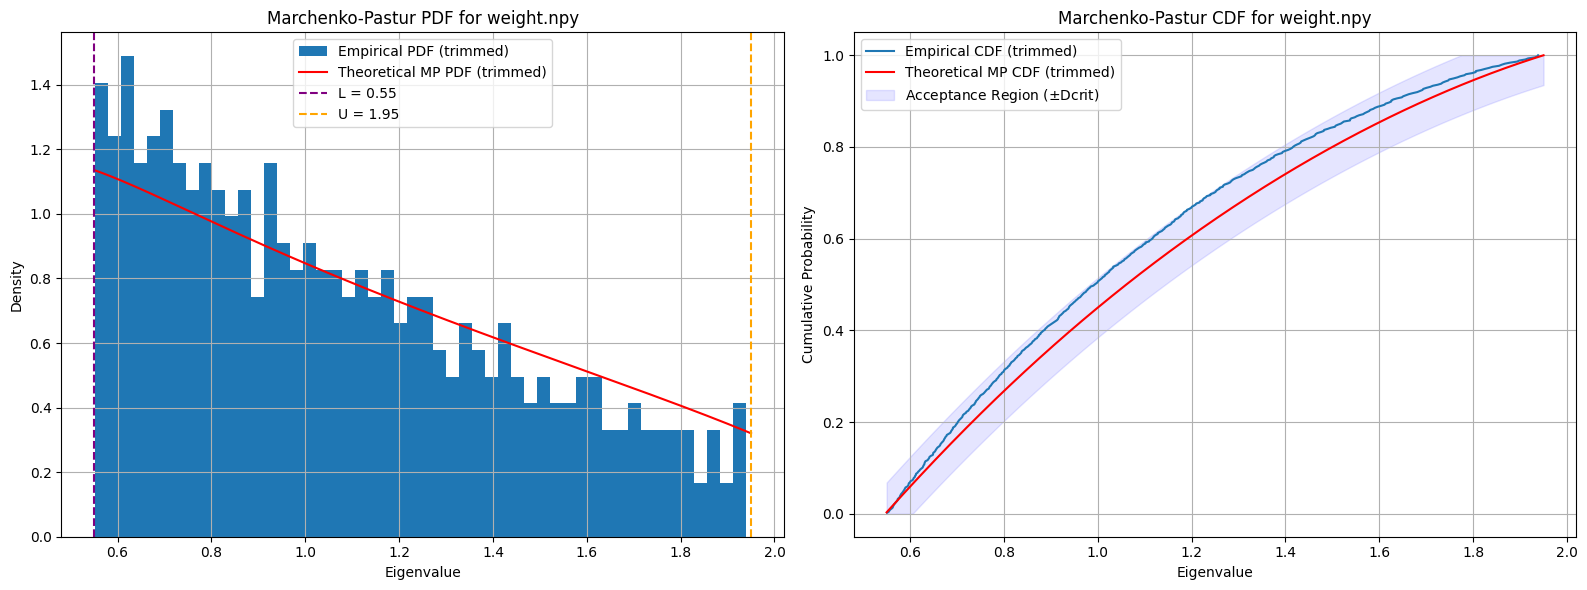


--- Choose a shrinkage method by uncommenting one line below ---

--- Applying gavish_donoho Shrinkage to encoder.layer.11.intermediate.dense.weight_WMP ---
Shapes before reconstruction: WMP_shrunk: (768, 3072), mu: (768,), sd: (768,)
✅ Denoised matrix reconstructed successfully.

--- Matrix Comparison Metrics ---
Original Sparsity: 0.00%
Shrunk Sparsity:   0.00%

Original Frobenius Norm: 60.1826
Shrunk Frobenius Norm:   48.5321
Frobenius Norm of Difference (Error): 35.5893
Relative Frobenius Norm Error: 0.5914

Cosine Similarity: 0.8064

Original Sum of Singular Values: 1547.2499
Shrunk Sum of Singular Values:   781.8500

Original Rank: 768
Shrunk Rank:   275
-----------------------------------

--- Generating Advanced Visual Plots ---


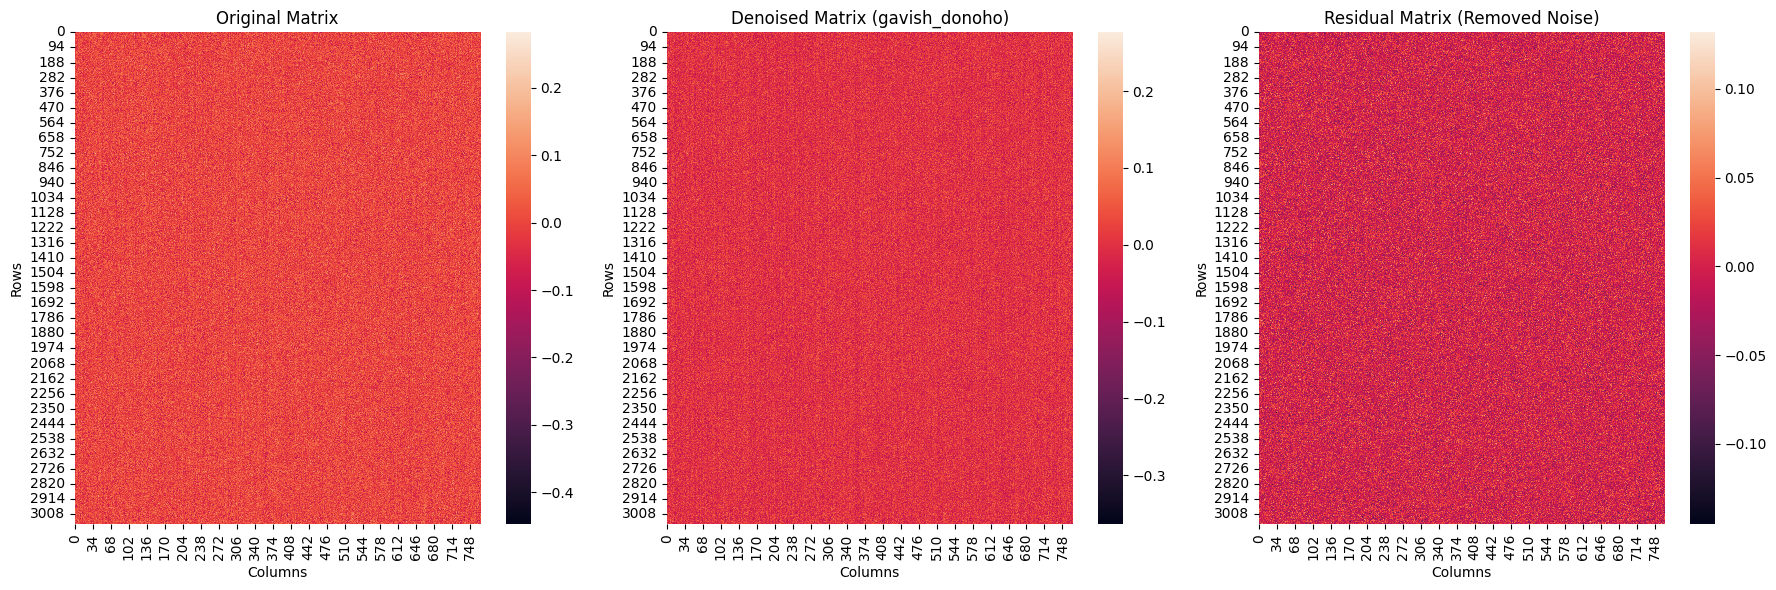

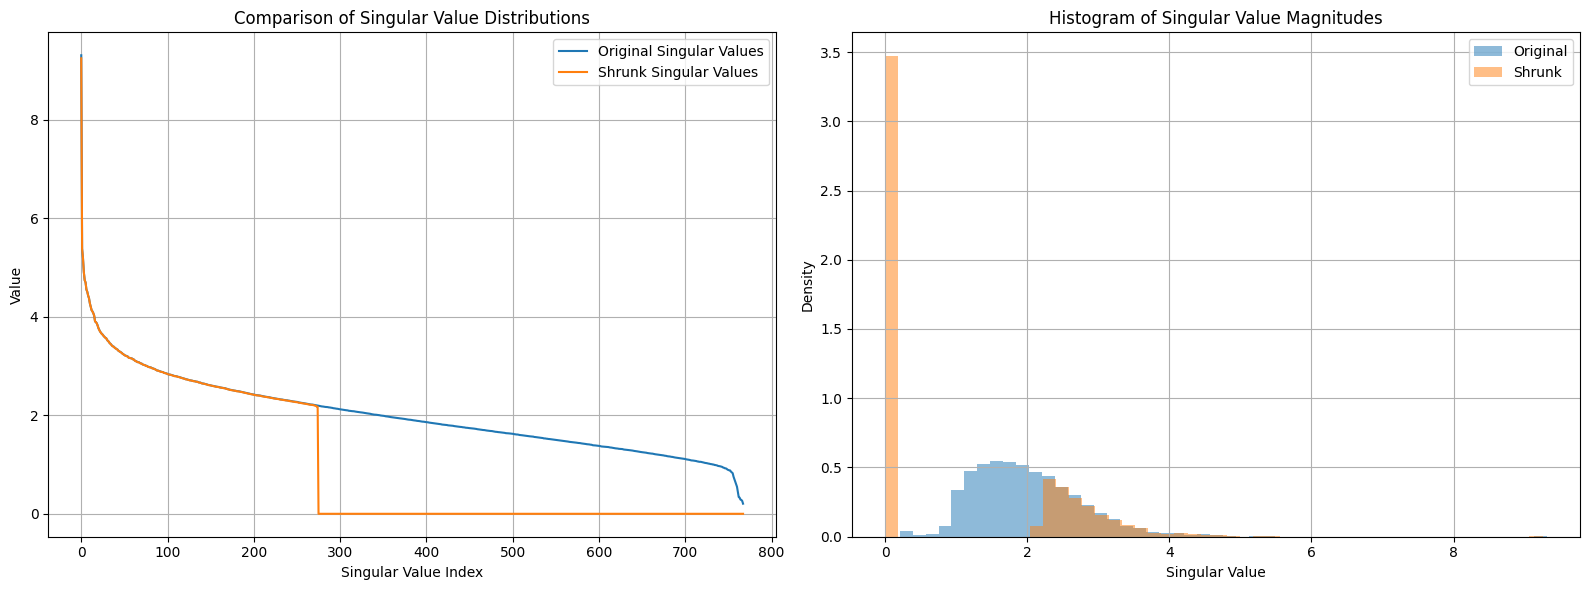

Denoised matrix saved to: denoised_weights/encoder/layer_11/intermediate/dense/weight.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import os
import warnings
import scipy.spatial.distance as ssd
import seaborn as sns

# --- Configuration ---
BERT_WEIGHTS_DIR = "bert_weights"
WMP_DIR = "bert_weights_WMP"
DENOISED_WEIGHTS_DIR = "denoised_weights"
MANIFEST_PATH = Path(WMP_DIR) / "manifest.json"
STATS_NPZ = "step1_column_stats.npz"

def get_wmp_matrices_from_manifest(manifest_file_path):
    """
    Loads the manifest file and returns a list of available WMP matrices.
    """
    if not os.path.exists(manifest_file_path):
        print(f"Error: Manifest file not found at '{manifest_file_path}'")
        return []

    with open(manifest_file_path, 'r') as f:
        manifest = json.load(f)

    return manifest['files']

def plot_marchenko_pastur(matrix_path, m, n, alpha=0.05):
    """
    Loads a WMP matrix, calculates its empirical and theoretical Marchenko-Pastur
    distributions (PDF and CDF), and plots them with Tracy-Widom trimming.
    Also performs a Kolmogorov-Smirnov test on the trimmed data.

    Returns:
        tuple: (L, U) the Tracy-Widom trimmed support limits.
    """
    try:
        WMP = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Error: Matrix file not found at '{matrix_path}'")
        return None, None

    if WMP.shape != (m, n):
        print(f"Warning: Provided dimensions ({m}x{n}) don't match matrix shape {WMP.shape}. Using matrix shape.")
        m, n = WMP.shape

    if m > n:
        print("Note: Transposing matrix to ensure m <= n for WMP calculation.")
        WMP = WMP.T
        m, n = WMP.shape

    q = m / n
    eigenvalues = np.linalg.eigvalsh((1/n) * WMP.T @ WMP)

    sigma_squared = 1.0
    lambda_minus = sigma_squared * (1 - np.sqrt(q))**2
    lambda_plus = sigma_squared * (1 + np.sqrt(q))**2

    beta = 1
    p = min(m, n)
    phi = 0.15
    ca = 1.5

    tw_scaled_term = ca * (p**(-2/3)) * ((1 + np.sqrt(beta))**(4/3))
    delta_beta = max(phi * (lambda_plus - lambda_minus), tw_scaled_term)

    L = lambda_minus + delta_beta
    U = lambda_plus - delta_beta

    print("--- Distribution Limits ---")
    print(f"Old Marchenko-Pastur support: [{lambda_minus:.4f}, {lambda_plus:.4f}]")
    print(f"Delta (trimming margin): {delta_beta:.4f}")
    print(f"New, trimmed support [L, U]: [{L:.4f}, {U:.4f}]")
    print("---------------------------")

    trimmed_eigenvalues = eigenvalues[(eigenvalues >= L) & (eigenvalues <= U)]

    if len(trimmed_eigenvalues) == 0:
        warnings.warn("No eigenvalues found within the trimmed [L, U] support. Skipping plot.")
        return None, None

    def theoretical_cdf_func(x):
        x_trimmed_grid = np.linspace(L, U, 5000)
        pdf_trimmed_grid = (1 / (2 * np.pi * sigma_squared * x_trimmed_grid * q)) * np.sqrt((lambda_plus - x_trimmed_grid) * (x_trimmed_grid - lambda_minus))
        pdf_trimmed_grid[~np.isfinite(pdf_trimmed_grid)] = 0

        cdf_vals = np.cumsum(pdf_trimmed_grid) * (x_trimmed_grid[1] - x_trimmed_grid[0])
        cdf_vals /= cdf_vals[-1]
        return np.interp(x, x_trimmed_grid, cdf_vals, left=0.0, right=1.0)

    n_trimmed = len(trimmed_eigenvalues)
    K_alpha = 1.358
    D_crit = K_alpha / np.sqrt(n_trimmed)

    sorted_trimmed_eigenvalues = np.sort(trimmed_eigenvalues)
    empirical_cdf = np.arange(1, len(sorted_trimmed_eigenvalues) + 1) / len(sorted_trimmed_eigenvalues)
    theoretical_cdf_vals = theoretical_cdf_func(sorted_trimmed_eigenvalues)
    D_max_stat = np.max(np.abs(empirical_cdf - theoretical_cdf_vals))
    h0_accepted = D_max_stat <= D_crit

    print("--- Kolmogorov-Smirnov Test Results ---")
    print(f"Number of trimmed eigenvalues (n): {n_trimmed}")
    print(f"D_max (Test Statistic): {D_max_stat:.4f}")
    print(f"D_crit (Critical Threshold at alpha={alpha}): {D_crit:.4f}")
    if h0_accepted:
        print("Result: ✅ H0 is accepted. The empirical CDF is a good fit for the theoretical CDF.")
    else:
        print("Result: ❌ H0 is rejected. The empirical CDF does not fit the theoretical CDF.")
    print("--------------------------------------")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    x_trimmed = np.linspace(L, U, 500)
    pdf_trimmed = (1 / (2 * np.pi * sigma_squared * x_trimmed * q)) * np.sqrt((lambda_plus - x_trimmed) * (x_trimmed - lambda_minus))
    pdf_trimmed[~np.isfinite(pdf_trimmed)] = 0
    pdf_trimmed /= np.sum(pdf_trimmed) * (x_trimmed[1] - x_trimmed[0])

    ax1.set_title(f"Marchenko-Pastur PDF for {os.path.basename(matrix_path)}")
    ax1.hist(trimmed_eigenvalues, bins=50, density=True, label="Empirical PDF (trimmed)")
    ax1.plot(x_trimmed, pdf_trimmed, 'r', label="Theoretical MP PDF (trimmed)")
    ax1.axvline(x=L, color='purple', linestyle='--', label=f"L = {L:.2f}")
    ax1.axvline(x=U, color='orange', linestyle='--', label=f"U = {U:.2f}")
    ax1.set_xlabel("Eigenvalue")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(True)

    empirical_cdf = np.arange(1, len(sorted_trimmed_eigenvalues) + 1) / len(sorted_trimmed_eigenvalues)
    theoretical_cdf = np.cumsum(pdf_trimmed) * (x_trimmed[1] - x_trimmed[0])
    theoretical_cdf /= theoretical_cdf[-1]

    ax2.set_title(f"Marchenko-Pastur CDF for {os.path.basename(matrix_path)}")
    ax2.plot(sorted_trimmed_eigenvalues, empirical_cdf, label="Empirical CDF (trimmed)")
    ax2.plot(x_trimmed, theoretical_cdf, 'r', label="Theoretical MP CDF (trimmed)")

    upper_bound = np.clip(theoretical_cdf + D_crit, 0, 1)
    lower_bound = np.clip(theoretical_cdf - D_crit, 0, 1)
    ax2.fill_between(x_trimmed, lower_bound, upper_bound, color='blue', alpha=0.1, label=r'Acceptance Region ($\pm$Dcrit)')

    ax2.set_xlabel("Eigenvalue")
    ax2.set_ylabel("Cumulative Probability")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return L, U

def shrinkage_svd(W, L, U, method="bulk_shrink", tau=0.1):
    """
    Applies shrinkage on singular values of weight matrix W.
    """
    m, n = W.shape
    U_svd, s, Vt = np.linalg.svd(W, full_matrices=False)

    s_shrunk = np.copy(s)
    sqrt_L = np.sqrt(L)
    sqrt_U = np.sqrt(U)

    if method == "bulk_shrink":
        mu = np.mean(s[(s >= sqrt_L) & (s <= sqrt_U)])
        s_shrunk[(s >= sqrt_L) & (s <= sqrt_U)] = mu
    elif method == "hard_threshold":
        s_shrunk[s < sqrt_L] = sqrt_L
        s_shrunk[s > sqrt_U] = sqrt_U
    elif method == "soft_threshold":
        s_shrunk = np.maximum(s - tau, 0)
    elif method == "gavish_donoho":
        beta = m / n
        omega = (4 / np.sqrt(3)) * np.sqrt(beta)
        threshold = omega * np.median(s)
        s_shrunk = np.where(s >= threshold, s, 0)
    else:
        raise ValueError(f"Unknown shrinkage method: {method}")

    W_hat = (U_svd * s_shrunk) @ Vt
    return W_hat, s_shrunk

def denoise_and_reconstruct_matrix(wmp_matrix_path, manifest_entry, stats_json, L, U, method):
    """
    Applies shrinkage to a standardized WMP matrix and reconstructs it.
    """
    print(f"\n--- Applying {method} Shrinkage to {manifest_entry['name']} ---")
    WMP = np.load(wmp_matrix_path)

    m, n = WMP.shape
    is_transposed = m > n
    if is_transposed:
        WMP = WMP.T

    WMP_shrunk, _ = shrinkage_svd(WMP, L, U, method=method)

    stats_npz = np.load(STATS_NPZ)
    original_entry = next((item for item in stats_json['files'] if item['name'] == manifest_entry['name'].replace("_WMP", "")), None)
    if not original_entry:
        raise ValueError("Could not find original matrix stats. Check step1_column_stats.json.")

    mu = stats_npz[original_entry['npz_keys']['mean']]
    sd = stats_npz[original_entry['npz_keys']['std']]

    print(f"Shapes before reconstruction: WMP_shrunk: {WMP_shrunk.shape}, mu: {mu.shape}, sd: {sd.shape}")

    safe_sd = np.where(sd == 0, 1.0, sd)

    if is_transposed:
        W_denoised = (WMP_shrunk * safe_sd.reshape(-1, 1)) + mu.reshape(-1, 1)
    else:
        W_denoised = (WMP_shrunk * safe_sd.reshape(1, -1)) + mu.reshape(1, -1)

    if is_transposed:
        W_denoised = W_denoised.T

    print(f"✅ Denoised matrix reconstructed successfully.")
    return W_denoised

def compare_matrices(original_matrix, shrunk_matrix):
    """
    Compares key characteristics of the original and shrunk weight matrices,
    including new metrics.
    """
    print("\n--- Matrix Comparison Metrics ---")

    original_sparsity = 100 * np.sum(original_matrix == 0) / original_matrix.size
    shrunk_sparsity = 100 * np.sum(shrunk_matrix == 0) / shrunk_matrix.size
    print(f"Original Sparsity: {original_sparsity:.2f}%")
    print(f"Shrunk Sparsity:   {shrunk_sparsity:.2f}%")

    original_norm = np.linalg.norm(original_matrix, 'fro')
    shrunk_norm = np.linalg.norm(shrunk_matrix, 'fro')
    print(f"\nOriginal Frobenius Norm: {original_norm:.4f}")
    print(f"Shrunk Frobenius Norm:   {shrunk_norm:.4f}")

    error_norm = np.linalg.norm(original_matrix - shrunk_matrix, 'fro')
    relative_error_norm = error_norm / original_norm
    print(f"Frobenius Norm of Difference (Error): {error_norm:.4f}")
    print(f"Relative Frobenius Norm Error: {relative_error_norm:.4f}")

    cosine_similarity = 1 - ssd.cosine(original_matrix.flatten(), shrunk_matrix.flatten())
    print(f"\nCosine Similarity: {cosine_similarity:.4f}")

    original_singular_values = np.linalg.svd(original_matrix, compute_uv=False)
    shrunk_singular_values = np.linalg.svd(shrunk_matrix, compute_uv=False)

    sum_orig = np.sum(original_singular_values)
    sum_shrunk = np.sum(shrunk_singular_values)
    print(f"\nOriginal Sum of Singular Values: {sum_orig:.4f}")
    print(f"Shrunk Sum of Singular Values:   {sum_shrunk:.4f}")

    rank_orig = np.linalg.matrix_rank(original_matrix)
    rank_shrunk = np.linalg.matrix_rank(shrunk_matrix)
    print(f"\nOriginal Rank: {rank_orig}")
    print(f"Shrunk Rank:   {rank_shrunk}")

    print("-----------------------------------")

def plot_advanced_visuals(original_matrix, shrunk_matrix, method_name):
    """
    Generates a series of advanced plots for a journal-quality report.
    """
    print("\n--- Generating Advanced Visual Plots ---")

    # Heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Matrix
    sns.heatmap(original_matrix, ax=axes[0], cbar=True)
    axes[0].set_title('Original Matrix')
    axes[0].set_xlabel('Columns')
    axes[0].set_ylabel('Rows')

    # Denoised Matrix
    sns.heatmap(shrunk_matrix, ax=axes[1], cbar=True)
    axes[1].set_title(f'Denoised Matrix ({method_name})')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Rows')

    # Residual Matrix (Noise)
    residual_matrix = original_matrix - shrunk_matrix
    sns.heatmap(residual_matrix, ax=axes[2], cbar=True)
    axes[2].set_title('Residual Matrix (Removed Noise)')
    axes[2].set_xlabel('Columns')
    axes[2].set_ylabel('Rows')

    plt.tight_layout()
    plt.show()

    # Singular Value Plots
    s_orig = np.linalg.svd(original_matrix, compute_uv=False)
    s_shrunk = np.linalg.svd(shrunk_matrix, compute_uv=False)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Line Plot
    axes[0].plot(s_orig, label="Original Singular Values")
    axes[0].plot(s_shrunk, label="Shrunk Singular Values")
    axes[0].set_title("Comparison of Singular Value Distributions")
    axes[0].set_xlabel("Singular Value Index")
    axes[0].set_ylabel("Value")
    axes[0].legend()
    axes[0].grid(True)

    # Histogram
    axes[1].hist(s_orig, bins=50, alpha=0.5, label="Original", density=True)
    axes[1].hist(s_shrunk, bins=50, alpha=0.5, label="Shrunk", density=True)
    axes[1].set_title("Histogram of Singular Value Magnitudes")
    axes[1].set_xlabel("Singular Value")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# --- Main execution ---
if __name__ == "__main__":
    try:
        wmp_manifest = get_wmp_matrices_from_manifest(MANIFEST_PATH)
        if not wmp_manifest:
            exit()

        with open("step1_column_stats.json", 'r') as f:
            stats_json = json.load(f)

    except FileNotFoundError as e:
        print(f"Error: Required file not found. Please ensure all previous steps have been run: {e}")
        exit()

    print("Available WMP matrices:")
    for i, entry in enumerate(wmp_manifest):
        print(f"[{i}] {entry['name']} (Shape: {entry['shape'][0]}x{entry['shape'][1]})")

    try:
        choice = int(input("Enter the number of the matrix you want to process: "))
    except (ValueError, EOFError):
        print("\nUsing default matrix choice as interactive input is not available or invalid.")
        choice = 0 # Fallback to the first matrix if interactive input fails.

    if 0 <= choice < len(wmp_manifest):
        selected_matrix = wmp_manifest[choice]
        wmp_matrix_path = os.path.join(WMP_DIR, selected_matrix['path'])
        m, n = selected_matrix['shape']

        L, U = plot_marchenko_pastur(wmp_matrix_path, m, n)

        if L is not None and U is not None:
            print("\n--- Choose a shrinkage method by uncommenting one line below ---")

            # Available shrinkage methods:
            # selected_method = "bulk_shrink"
            # selected_method = "hard_threshold"
            # selected_method = "soft_threshold"
            selected_method = "gavish_donoho" # Default choice

            # Then, perform the denoising using the chosen method
            denoised_matrix = denoise_and_reconstruct_matrix(wmp_matrix_path, selected_matrix, stats_json, L, U, selected_method)

            # Load the original matrix for comparison
            original_matrix_name = selected_matrix['path'].replace("_WMP.npy", ".npy")
            original_matrix_path = os.path.join(BERT_WEIGHTS_DIR, original_matrix_name)
            original_matrix = np.load(original_matrix_path)

            # Compare the characteristics and generate report
            compare_matrices(original_matrix, denoised_matrix)
            plot_advanced_visuals(original_matrix, denoised_matrix, selected_method)

            # Optional: Save the denoised matrix
            output_path = os.path.join(DENOISED_WEIGHTS_DIR, selected_matrix['path'])
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            np.save(output_path, denoised_matrix)
            print(f"Denoised matrix saved to: {output_path}")

    else:
        print("Invalid matrix choice. Please set 'choice' to a number from the list.")

# All-in-One BERT Denoising Report Generator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pathlib import Path
import os
import warnings
import scipy.spatial.distance as ssd
import seaborn as sns

# --- Configuration ---
BERT_WEIGHTS_DIR = "bert_weights"
WMP_DIR = "bert_weights_WMP"
DENOISED_WEIGHTS_DIR = "denoised_weights"
MANIFEST_PATH = Path(WMP_DIR) / "manifest.json"
STATS_NPZ = "step1_column_stats.npz"
FIGURES_DIR = "denoised_weights/figures"

# Create directories if they don't exist
os.makedirs(DENOISED_WEIGHTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)


def get_wmp_matrices_from_manifest(manifest_file_path):
    """
    Loads the manifest file and returns a list of available WMP matrices.
    """
    if not os.path.exists(manifest_file_path):
        print(f"Error: Manifest file not found at '{manifest_file_path}'")
        return []
    with open(manifest_file_path, 'r') as f:
        manifest = json.load(f)
    return manifest['files']


def plot_marchenko_pastur(matrix_path, m, n, alpha=0.05, save_path=None):
    """
    Loads a WMP matrix, plots its empirical and theoretical Marchenko-Pastur
    distributions, and saves the plot.
    """
    try:
        WMP = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Error: Matrix file not found at '{matrix_path}'")
        return None, None
    if WMP.shape != (m, n):
        m, n = WMP.shape
    if m > n:
        WMP = WMP.T
        m, n = WMP.shape
    q = m / n
    eigenvalues = np.linalg.eigvalsh((1 / n) * WMP.T @ WMP)

    sigma_squared = 1.0
    lambda_minus = sigma_squared * (1 - np.sqrt(q)) ** 2
    lambda_plus = sigma_squared * (1 + np.sqrt(q)) ** 2

    beta = 1
    p = min(m, n)
    phi = 0.15
    ca = 1.5
    tw_scaled_term = ca * (p ** (-2 / 3)) * ((1 + np.sqrt(beta)) ** (4 / 3))
    delta_beta = max(phi * (lambda_plus - lambda_minus), tw_scaled_term)

    L = lambda_minus + delta_beta
    U = lambda_plus - delta_beta
    trimmed_eigenvalues = eigenvalues[(eigenvalues >= L) & (eigenvalues <= U)]

    if len(trimmed_eigenvalues) == 0:
        warnings.warn("No eigenvalues found within the trimmed [L, U] support.")
        return None, None

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    x_trimmed = np.linspace(L, U, 500)
    pdf_trimmed = (1 / (2 * np.pi * sigma_squared * x_trimmed * q)) * np.sqrt(
        (lambda_plus - x_trimmed) * (x_trimmed - lambda_minus))
    pdf_trimmed[~np.isfinite(pdf_trimmed)] = 0
    pdf_trimmed /= np.sum(pdf_trimmed) * (x_trimmed[1] - x_trimmed[0])
    ax1.set_title(f"Marchenko-Pastur PDF for {os.path.basename(matrix_path)}")
    ax1.hist(trimmed_eigenvalues, bins=50, density=True, label="Empirical PDF (trimmed)")
    ax1.plot(x_trimmed, pdf_trimmed, 'r', label="Theoretical MP PDF (trimmed)")
    ax1.set_xlabel("Eigenvalue")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(True)

    sorted_trimmed_eigenvalues = np.sort(trimmed_eigenvalues)
    empirical_cdf = np.arange(1, len(sorted_trimmed_eigenvalues) + 1) / len(sorted_trimmed_eigenvalues)

    def theoretical_cdf_func(x):
        x_trimmed_grid = np.linspace(L, U, 5000)
        pdf_trimmed_grid = (1 / (2 * np.pi * sigma_squared * x_trimmed_grid * q)) * np.sqrt(
            (lambda_plus - x_trimmed_grid) * (x_trimmed_grid - lambda_minus))
        pdf_trimmed_grid[~np.isfinite(pdf_trimmed_grid)] = 0
        cdf_vals = np.cumsum(pdf_trimmed_grid) * (x_trimmed_grid[1] - x_trimmed_grid[0])
        cdf_vals /= cdf_vals[-1]
        return np.interp(x, x_trimmed_grid, cdf_vals, left=0.0, right=1.0)

    theoretical_cdf_vals = theoretical_cdf_func(sorted_trimmed_eigenvalues)

    ax2.set_title(f"Marchenko-Pastur CDF for {os.path.basename(matrix_path)}")
    ax2.plot(sorted_trimmed_eigenvalues, empirical_cdf, label="Empirical CDF (trimmed)")
    ax2.plot(x_trimmed, np.cumsum(pdf_trimmed) * (x_trimmed[1] - x_trimmed[0]) / (
                np.cumsum(pdf_trimmed)[-1] * (x_trimmed[1] - x_trimmed[0])), 'r', label="Theoretical MP CDF (trimmed)")
    ax2.set_xlabel("Eigenvalue")
    ax2.set_ylabel("Cumulative Probability")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    return L, U


def shrinkage_svd(W, L, U, method="gavish_donoho"):
    """
    Applies shrinkage on singular values of weight matrix W.
    """
    m, n = W.shape
    U_svd, s, Vt = np.linalg.svd(W, full_matrices=False)
    s_shrunk = np.copy(s)

    if method == "gavish_donoho":
        beta = m / n
        omega = (4 / np.sqrt(3)) * np.sqrt(beta)
        threshold = omega * np.median(s)
        s_shrunk = np.where(s >= threshold, s, 0)
    else:
        raise ValueError(f"Unknown shrinkage method: {method}")

    W_hat = (U_svd * s_shrunk) @ Vt
    return W_hat, s_shrunk


def denoise_and_reconstruct_matrix(wmp_matrix_path, manifest_entry, stats_json, L, U, method):
    """
    Applies shrinkage to a standardized WMP matrix and reconstructs it.
    """
    WMP = np.load(wmp_matrix_path)
    m, n = WMP.shape
    is_transposed = m > n
    if is_transposed:
        WMP = WMP.T

    WMP_shrunk, _ = shrinkage_svd(WMP, L, U, method=method)

    stats_npz = np.load(STATS_NPZ)
    original_entry = next(
        (item for item in stats_json['files'] if item['name'] == manifest_entry['name'].replace("_WMP", "")), None)
    if not original_entry:
        raise ValueError("Could not find original matrix stats. Check step1_column_stats.json.")

    mu = stats_npz[original_entry['npz_keys']['mean']]
    sd = stats_npz[original_entry['npz_keys']['std']]
    safe_sd = np.where(sd == 0, 1.0, sd)

    if is_transposed:
        W_denoised = (WMP_shrunk * safe_sd.reshape(-1, 1)) + mu.reshape(-1, 1)
    else:
        W_denoised = (WMP_shrunk * safe_sd.reshape(1, -1)) + mu.reshape(1, -1)

    if is_transposed:
        W_denoised = W_denoised.T

    return W_denoised


def get_metrics(original_matrix, shrunk_matrix):
    """
    Calculates key comparison metrics and returns them in a dictionary.
    """
    original_sparsity = 100 * np.sum(original_matrix == 0) / original_matrix.size
    shrunk_sparsity = 100 * np.sum(shrunk_matrix == 0) / shrunk_matrix.size
    original_norm = np.linalg.norm(original_matrix, 'fro')
    shrunk_norm = np.linalg.norm(shrunk_matrix, 'fro')
    error_norm = np.linalg.norm(original_matrix - shrunk_matrix, 'fro')
    relative_error_norm = error_norm / original_norm
    cosine_similarity = 1 - ssd.cosine(original_matrix.flatten(), shrunk_matrix.flatten())
    rank_orig = np.linalg.matrix_rank(original_matrix)
    rank_shrunk = np.linalg.matrix_rank(shrunk_matrix)

    return {
        'Original Sparsity (%)': original_sparsity,
        'Shrunk Sparsity (%)': shrunk_sparsity,
        'Original Frobenius Norm': original_norm,
        'Shrunk Frobenius Norm': shrunk_norm,
        'Relative Frobenius Error': relative_error_norm,
        'Cosine Similarity': cosine_similarity,
        'Original Rank': rank_orig,
        'Shrunk Rank': rank_shrunk
    }


def plot_advanced_visuals(original_matrix, shrunk_matrix, matrix_name, save_path=None):
    """
    Generates a series of advanced plots and saves the figure.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(original_matrix, ax=axes[0], cbar=True)
    axes[0].set_title('Original Matrix')
    axes[0].set_xlabel('Columns')
    axes[0].set_ylabel('Rows')

    sns.heatmap(shrunk_matrix, ax=axes[1], cbar=True)
    axes[1].set_title(f'Denoised Matrix')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Rows')

    residual_matrix = original_matrix - shrunk_matrix
    sns.heatmap(residual_matrix, ax=axes[2], cbar=True)
    axes[2].set_title('Residual Matrix (Removed Noise)')
    axes[2].set_xlabel('Columns')
    axes[2].set_ylabel('Rows')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)


# --- Main execution ---
if __name__ == "__main__":
    try:
        wmp_manifest = get_wmp_matrices_from_manifest(MANIFEST_PATH)
        if not wmp_manifest:
            print("No WMP matrices found. Exiting.")
            exit()

        with open("step1_column_stats.json", 'r') as f:
            stats_json = json.load(f)
    except FileNotFoundError as e:
        print(f"Error: Required file not found. Please ensure all previous steps have been run: {e}")
        exit()

    # --- PART 1: Process and save metrics incrementally ---
    selected_method = "gavish_donoho"
    report_file_path = os.path.join(DENOISED_WEIGHTS_DIR, "denoising_report_metrics.csv")

    # Write the header to the CSV file
    with open(report_file_path, 'w') as f:
        header = ['Matrix Name', 'Original Sparsity (%)', 'Shrunk Sparsity (%)',
                  'Original Frobenius Norm', 'Shrunk Frobenius Norm',
                  'Relative Frobenius Error', 'Cosine Similarity',
                  'Original Rank', 'Shrunk Rank']
        f.write(','.join(header) + '\n')

    print(f"--- Starting Denoising for all BERT Layers using {selected_method} ---")

    for i, entry in enumerate(wmp_manifest):

        # Check if the matrix is the large word embeddings matrix and skip it
        if 'embeddings.word_embeddings.weight' in entry['name']:
            print(f"\nSkipping large matrix: {entry['name']}")
            continue

        print(f"\nProcessing matrix [{i + 1}/{len(wmp_manifest)}]: {entry['name']}")

        try:
            wmp_matrix_path = os.path.join(WMP_DIR, entry['path'])
            original_matrix_name = entry['path'].replace("_WMP.npy", ".npy")
            original_matrix_path = os.path.join(BERT_WEIGHTS_DIR, original_matrix_name)
            original_matrix = np.load(original_matrix_path)

            m, n = entry['shape']

            mp_plot_path = os.path.join(FIGURES_DIR, f"{entry['name']}_mp_plot.png")
            L, U = plot_marchenko_pastur(wmp_matrix_path, m, n, save_path=mp_plot_path)

            if L is None or U is None:
                print(f"Skipping {entry['name']} due to invalid MP distribution.")
                continue

            denoised_matrix = denoise_and_reconstruct_matrix(wmp_matrix_path, entry, stats_json, L, U, selected_method)

            metrics = get_metrics(original_matrix, denoised_matrix)
            metrics['Matrix Name'] = entry['name']

            # Append a single row to the CSV file
            with open(report_file_path, 'a') as f:
                row_data = [
                    metrics['Matrix Name'],
                    f"{metrics['Original Sparsity (%)']:.4f}",
                    f"{metrics['Shrunk Sparsity (%)']:.4f}",
                    f"{metrics['Original Frobenius Norm']:.4f}",
                    f"{metrics['Shrunk Frobenius Norm']:.4f}",
                    f"{metrics['Relative Frobenius Error']:.4f}",
                    f"{metrics['Cosine Similarity']:.4f}",
                    metrics['Original Rank'],
                    metrics['Shrunk Rank']
                ]
                f.write(','.join(map(str, row_data)) + '\n')

            output_path = os.path.join(DENOISED_WEIGHTS_DIR, original_matrix_name)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            np.save(output_path, denoised_matrix)

            visuals_plot_path = os.path.join(FIGURES_DIR, f"{entry['name']}_visuals.png")
            plot_advanced_visuals(original_matrix, denoised_matrix, entry['name'], save_path=visuals_plot_path)

            # Manually free up memory by deleting large objects
            del original_matrix
            del denoised_matrix

        except Exception as e:
            print(f"An error occurred while processing {entry['name']}: {e}")
            continue

    # --- PART 2: Load the complete report and display ---
    print("\n" + "=" * 80)
    print("                   📊 BERT Denoising Report - Summary Metrics")
    print("=" * 80)

    try:
        df = pd.read_csv(report_file_path).set_index('Matrix Name')
        print(df.to_string())

        print("\nReport metrics saved to 'denoising_report_metrics.csv'")
        print(f"All generated figures saved to '{FIGURES_DIR}'")
        print("Denoised weight matrices saved to 'denoised_weights'")
        print("=" * 80)
    except FileNotFoundError:
        print("\nNo matrices were successfully processed. No final report generated.")

--- Starting Denoising for all BERT Layers using gavish_donoho ---

Processing matrix [1/76]: encoder.layer.0.attention.output.dense.weight_WMP

Processing matrix [2/76]: encoder.layer.0.attention.self.key.weight_WMP

Processing matrix [3/76]: encoder.layer.0.attention.self.query.weight_WMP

Processing matrix [4/76]: encoder.layer.0.attention.self.value.weight_WMP

Processing matrix [5/76]: encoder.layer.0.intermediate.dense.weight_WMP

Processing matrix [6/76]: encoder.layer.0.output.dense.weight_WMP

Processing matrix [7/76]: encoder.layer.1.attention.output.dense.weight_WMP

Processing matrix [8/76]: encoder.layer.1.attention.self.key.weight_WMP

Processing matrix [9/76]: encoder.layer.1.attention.self.query.weight_WMP

Processing matrix [10/76]: encoder.layer.1.attention.self.value.weight_WMP

Processing matrix [11/76]: encoder.layer.1.intermediate.dense.weight_WMP

Processing matrix [12/76]: encoder.layer.1.output.dense.weight_WMP

Processing matrix [13/76]: encoder.layer.10.atten